In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pydicom as dicom
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score


2024-04-20 06:49:14.965182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 06:49:14.965351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 06:49:15.161829: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Step 1: Load Data
df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
df = df.rename(columns={'anatom_site_general_challenge': 'site'})

# Step 2: Display Initial Data
print(df.head())


     image_name  patient_id     sex  age_approx             site diagnosis  \
0  ISIC_2637011  IP_7279968    male        45.0        head/neck   unknown   
1  ISIC_0015719  IP_3075186  female        45.0  upper extremity   unknown   
2  ISIC_0052212  IP_2842074  female        50.0  lower extremity     nevus   
3  ISIC_0068279  IP_6890425  female        45.0        head/neck   unknown   
4  ISIC_0074268  IP_8723313  female        55.0  upper extremity   unknown   

  benign_malignant  target  
0           benign       0  
1           benign       0  
2           benign       0  
3           benign       0  
4           benign       0  


In [4]:
# Step 3: Data Balancing and Splitting
# Count the number of samples for each class
count_0 = df[df.target == 0].shape[0]
count_1 = df[df.target == 1].shape[0]

# Sample without replacement for each class
s0 = df[df.target == 0].sample(min(500, count_0), random_state=1).index
s1 = df[df.target == 1].sample(min(600, count_1), random_state=1).index

balanced_indices = s0.union(s1)
balanced_df = df.loc[balanced_indices]

train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)


In [5]:
# Step 4: Load and Process Images for Training
train_images = []
for x in train_df['image_name']:
    image = '/kaggle/input/siim-isic-melanoma-classification/train/' + x + '.dcm'
    ds = dicom.dcmread(image)
    pixels = ds.pixel_array
    train_images.append(pixels.flatten())

    # Image Padding for Training
train_images = tf.keras.preprocessing.sequence.pad_sequences(
    train_images,
    maxlen=720,
    dtype="int32",
    padding="pre",
    truncating="pre",
    value=0
)

/opt/conda/lib/python3.10/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '"1.2.840.10008.5.1.4.1.1.77.1.4"'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


In [6]:
# Step 5: Load and Process Images for Testing
test_images = []
for x in test_df['image_name']:
    image = '/kaggle/input/siim-isic-melanoma-classification/train/' + x + '.dcm'
    ds = dicom.dcmread(image)
    pixels = ds.pixel_array
    test_images.append(pixels.flatten())

# Image Padding for Testing
test_images = tf.keras.preprocessing.sequence.pad_sequences(
    test_images,
    maxlen=720,
    dtype="int32",
    padding="pre",
    truncating="pre",
    value=0
)

In [6]:
# Step 6: Model Training - SVM
X_train_svm = train_images
y_train_svm = np.array(train_df['target'])
classifier_svm = svm.SVC(probability=True, random_state=42)
classifier_svm.fit(X_train_svm, y_train_svm)


SVC(probability=True, random_state=42)

In [8]:
# Step 7: Model Training - Logistic Regression
X_train_lr = train_images
y_train_lr = np.array(train_df['target'])
classifier_lr = LogisticRegression(random_state=42)
classifier_lr.fit(X_train_lr, y_train_lr)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [9]:
# Step 8: Model Evaluation - Accuracy and Confusion Matrix for SVM
X_test_svm = test_images
y_test_svm = np.array(test_df['target'])
y_pred_svm = classifier_svm.predict(X_test_svm)
print('Accuracy Score SVM: ', accuracy_score(y_test_svm, y_pred_svm))
print('Confusion Matrix SVM: \n', confusion_matrix(y_test_svm, y_pred_svm))

Accuracy Score SVM:  0.6728110599078341
Confusion Matrix SVM: 
 [[62 33]
 [38 84]]


In [10]:
# Step 9: Model Evaluation - Accuracy and Confusion Matrix for Logistic Regression
X_test_lr = test_images
y_test_lr = np.array(test_df['target'])
y_pred_lr = classifier_lr.predict(X_test_lr)
print('Accuracy Score Logistic Regression: ', accuracy_score(y_test_lr, y_pred_lr))
print('Confusion Matrix Logistic Regression: \n', confusion_matrix(y_test_lr, y_pred_lr))

Accuracy Score Logistic Regression:  0.5714285714285714
Confusion Matrix Logistic Regression: 
 [[54 41]
 [52 70]]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


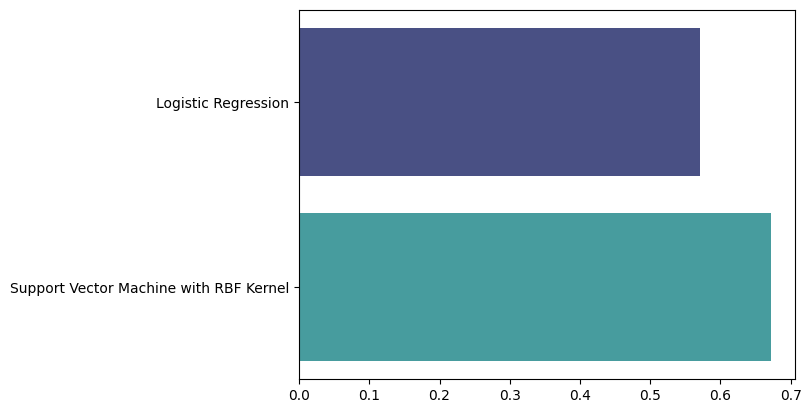

In [11]:
# Step 10: Visualization
x_l = ['Logistic Regression', 'Support Vector Machine with RBF Kernel']
y_l = [accuracy_score(y_test_lr, y_pred_lr), accuracy_score(y_test_svm, y_pred_svm)]
sns.barplot(x=y_l, y=x_l, palette="mako")
plt.show()


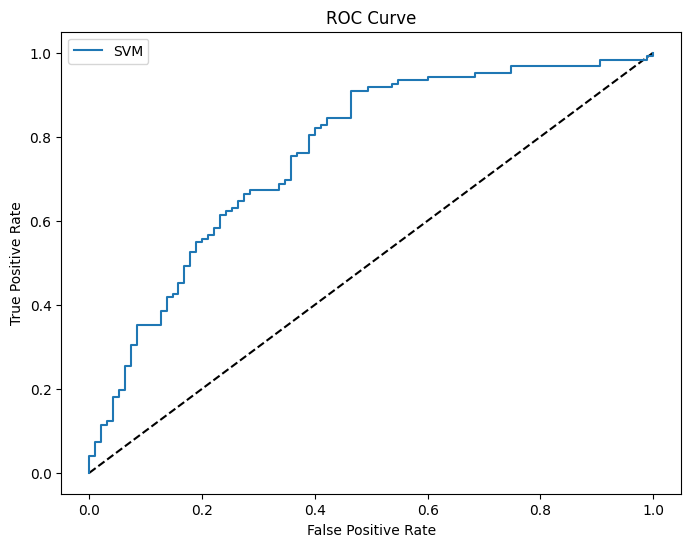

In [12]:
#ROC
svm_probs = classifier_svm.predict_proba(X_test_svm)[:, 1]


fpr_svm, tpr_svm, _ = roc_curve(test_df['target'], svm_probs)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


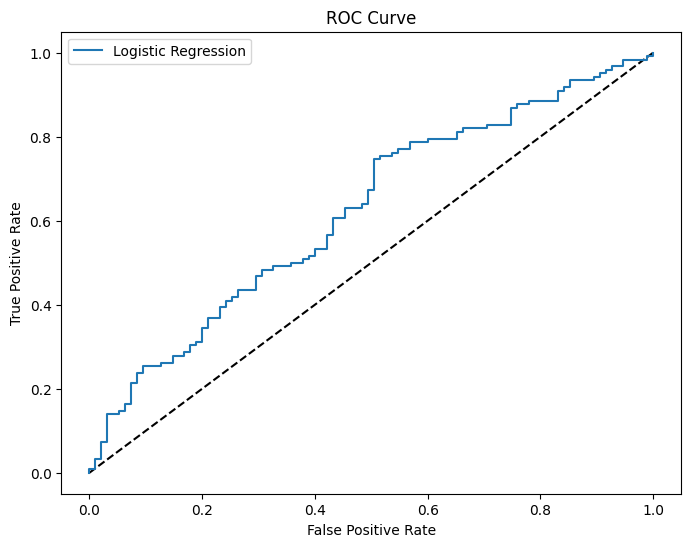

In [14]:
lr_probs = classifier_lr.predict_proba(X_test_lr)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(test_df['target'], lr_probs)
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


In [15]:
#Recall and precision score and F1 score
f1_svm = f1_score(test_df['target'], y_pred_svm)
f1_lr = f1_score(test_df['target'], y_pred_lr)
precision_svm = precision_score(test_df['target'], y_pred_svm)
precision_lr = precision_score(test_df['target'], y_pred_lr)
recall_svm = recall_score(test_df['target'], y_pred_svm)
recall_lr = recall_score(test_df['target'], y_pred_lr)

print(f'F1 Score SVM: {f1_svm}')
print(f'F1 Score Logistic Regression: {f1_lr}')
print(f'Precision SVM: {precision_svm}')
print(f'Precision Logistic Regression: {precision_lr}')
print(f'Recall SVM: {recall_svm}')
print(f'Recall Logistic Regression: {recall_lr}')


F1 Score SVM: 0.7029288702928871
F1 Score Logistic Regression: 0.6008583690987124
Precision SVM: 0.717948717948718
Precision Logistic Regression: 0.6306306306306306
Recall SVM: 0.6885245901639344
Recall Logistic Regression: 0.5737704918032787


Text(120.72222222222221, 0.5, 'Actual')

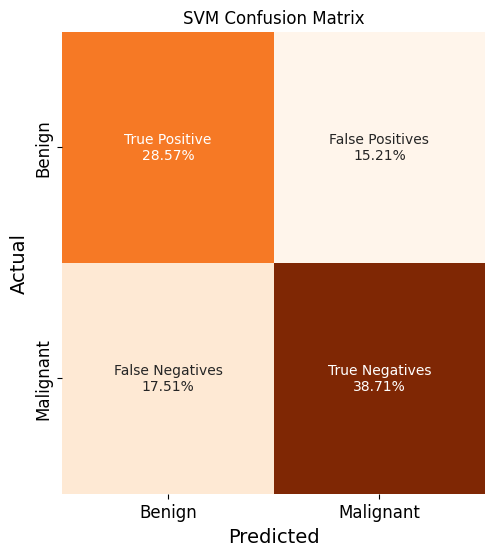

In [16]:
# Compute confusion matrices
svm_cm = confusion_matrix(y_test_svm, y_pred_svm)


names = ['True Positive', 'False Positives', 'False Negatives', 'True Negatives']
counts = ['{0:0.0f}'.format(value) for value in svm_cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in svm_cm.flatten()/np.sum(svm_cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
labels = np.asarray(labels).reshape(2,2)
ticklabels = ['Benign', 'Malignant']

# Plot confusion matrix for SVM
# Create confusion matrix as heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
ax = sns.heatmap(svm_cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels, cbar=False )
plt.xticks(size=12)
plt.yticks(size=12)
plt.title("SVM Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
plt.xlabel("Predicted", size=14)
plt.ylabel("Actual", size=14) 




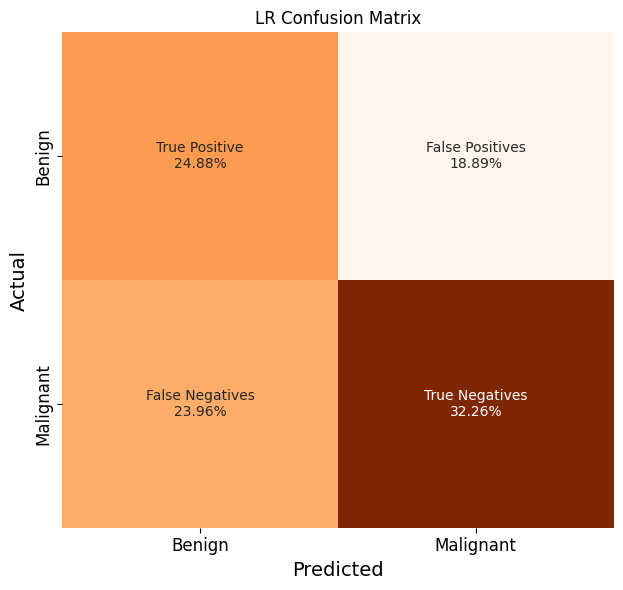

In [18]:
lr_cm = confusion_matrix(y_test_lr, y_pred_lr)
names = ['True Positive', 'False Positives', 'False Negatives', 'True Negatives']
counts = ['{0:0.0f}'.format(value) for value in lr_cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in lr_cm.flatten()/np.sum(lr_cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
labels = np.asarray(labels).reshape(2,2)
ticklabels = ['Benign', 'Malignant']
# Plot confusion matrix for Logistic Regression
# Create confusion matrix as heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
ax = sns.heatmap(lr_cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels, cbar=False )
plt.xticks(size=12)
plt.yticks(size=12)
plt.title("LR Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
plt.xlabel("Predicted", size=14)
plt.ylabel("Actual", size=14) 


plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '"1.2.840.10008.5.1.4.1.1.77.1.4"'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


Result from SVM:  Benign
Result from Logistic Regression: Benign


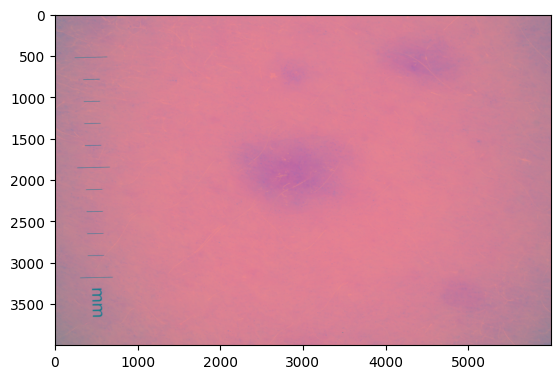

In [19]:
image_path = '/kaggle/input/siim-isic-melanoma-classification/test/ISIC_0116844.dcm'
details = [[55,0,0,0,1,1,0]]
image_to_test = []
ds = dicom.dcmread(image_path)
pixels = ds.pixel_array
plt.imshow(pixels)
image_to_test.append(pixels.flatten())

image_to_test = tf.keras.preprocessing.sequence.pad_sequences(
  image_to_test,
  maxlen = 720,
  dtype = "int32",
  padding = "pre",
  truncating = "pre",
  value = 0
)



if classifier_svm.predict(image_to_test) == [1]:
    result2 = 'Malignant'
else:
    result2 = 'Benign'

print('Result from SVM: ', result2)

if classifier_lr.predict(image_to_test) == [1]:
    result2 = 'Malignant'
else:
    result2 = 'Benign'

print('Result from Logistic Regression:', result2)

In [ ]:
#to test on image
from PIL import Image


# Load the JPEG image
image_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test/ISIC_0058510.jpg'
image = Image.open(image_path)
pixels = image.resize((720, 720))  # Resize the image to 720x720
pixels = pixels.convert("L")  # Convert to grayscale
pixels = tf.keras.preprocessing.image.img_to_array(pixels)

# Flatten and pad the image
image_to_test = tf.keras.preprocessing.sequence.pad_sequences(
    [pixels.flatten()],
    maxlen=720 * 720,
    dtype="float32",
    padding="pre",
    truncating="pre",
    value=0
)


# Reshape the image_to_test array to match the SVM classifier input dimensions
image_to_test_reshaped = image_to_test.reshape(-1, 720)  # Reshape to have 720 features



# Predict using SVM
svm_prediction = classifier_svm.predict(image_to_test_reshaped)
if 1 in svm_prediction:
    result_svm = 'Malignant'
else:
    result_svm = 'Benign'

print('Result from SVM:', result_svm)

# Predict using Logistic Regression
lr_prediction = classifier_lr.predict(image_to_test_reshaped)
if 1 in lr_prediction:
    result_lr = 'Malignant'
else:
    result_lr = 'Benign'

print('Result from Logistic Regression:', result_lr)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.title('Test Image')
plt.show()